<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/01_logisitc_regression_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import requests
from pathlib import Path 

request = requests.get("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/utils/utils.py")
with open("utils.py", "wb") as f:
  f.write(request.content)

from utils import plot_decision_boundary

In [2]:
#@title
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Logitic regression in PyTorch


[PyTorch](https://pytorch.org/) is an open source deep learning framework. 

In this notebook we will look at a training and evaluation workflow for fitting a logistic regression model on a toy dataset.

First, we import the required PyTorch libraries and fix the random seed.

In [3]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

A tyical PyTorch workflow involves:

- Preparing the data
- Building the model
- Fitting the model to the data (training)
- Computing predictions and evaluating the model
- Saving the model

Let's discuss these steps in more detail by building and fitting a logistic regression model.

## Preparing the data

The dataset is in a flat file called `dataset_logistic_regression.csv`. 

We read this file into a Pandas DataFrame.

In [4]:
import pandas as pd

data_path = "https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/datasets/dataset_logistic_regression.csv"

dataset = pd.read_csv(data_path)

dataset.head()

,x_1,x_2,y
0,0.716568,-1.039137,1
1,0.690542,-1.502750,1
2,-0.005533,-1.093649,1
3,-0.857466,0.420568,0
4,-1.305446,1.366230,0


The dataset as two features `x_1` and `x_2`, and one label `y`. 

Let's plot this data. 

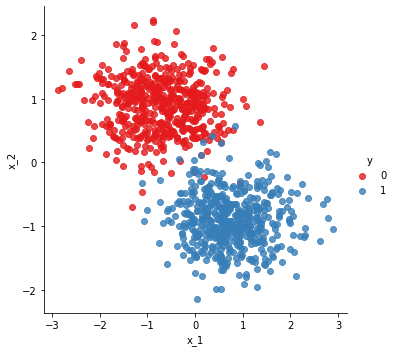

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False, palette="Set1")
plt.show()

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame (or Series) called `y`.

In [6]:
y = dataset.pop('y')
X = dataset

A typical deep learning workflow would involve a train, a validation and a test split of the dataset. 

The train set is used to fit the modelparameters. 

The validation set is used to evaluate different hyperparameter values. 

The test set is used to estimate the exppected prediction error on unseen external data. The data in the test set should not be used of training the network, nor for evaluating different hyperparameter values.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In PyTorch we work with tensor representaions of the dataset. A PyTorch Tensor is basically the same as a numpy array, it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array optimized for arbitrary numeric computation.

To create a tensor we need to first extract the numpy data from the Pandas DataFrames.

In [8]:
type(X_train)

pandas.core.frame.DataFrame

In [9]:
X_train, X_val, X_test = X_train.values, X_val.values, X_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

In [10]:
type(X_train)

numpy.ndarray

Now we can create the Tensors.

In [11]:
X_train, X_val, X_test = torch.Tensor(X_train),torch.Tensor(X_val),torch.Tensor(X_test)
y_train, y_val, y_test = torch.Tensor(y_train),torch.Tensor(y_val),torch.Tensor(y_test)

In [12]:
type(X_train)

torch.Tensor

## Building the model

To build a model in PyTorch we need to create a subclass of `torch.nn.Module` such that this subclass inherits all functionality required for fitting our model.

The following code builds a logistic regression model as a class called `LogisticRegression`.

In [13]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()

    self.linear = torch.nn.Linear(input_dim, output_dim)   
    
    torch.nn.init.normal_(self.linear.weight) 
    torch.nn.init.normal_(self.linear.bias) 

  def forward(self, x):
    x = self.linear(x)
    return x

This class implements at least two methods: `__init__()` and `forward()`.

### `__init()__`



In this function we declare all the layers we want to use. For the logistic regression model we need one linear layer `torch.nn.Linear`, which is a single layer feed forward network with `input_dim` inputs and `output_dim` outputs.

The method `__init__()` is called when an instance of our class `LogisticRegression` is created.

In [14]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

model = LogisticRegression(input_dim, output_dim)

We now created a `LogisticRegression` instance called `model` that has three  modelparameters: one for each feature `x_1` and `x_2` (aka weights) and one bias (`x_0`). 

As this class inherits all functionality of the `totch.nn.Module` class, we can now, for instance, call the inherited `.state_dict()` method to get the state (what the model contains) of our model.

In [15]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-0.2668,  1.5554]])),
             ('linear.bias', tensor([-0.5727]))])

We can access these modelparameters as follows.

In [16]:
model.linear.weight

Parameter containing:
tensor([[-0.2668,  1.5554]], requires_grad=True)

We used `torch.nn.init.uniform_()` to set the initial values of the modelparameters by random sampling from a normal disribution with mean equal to zero and standard deviation equal to one.

The following code plots the initial decision boundary of our model. 

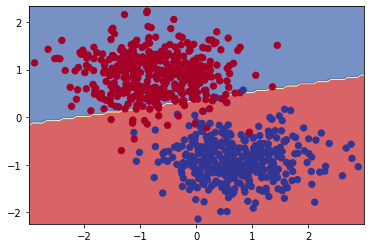

In [17]:
plot_decision_boundary(model, X_train, y_train)

### `forward()`

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

In this method we pass a feature vector `x` trough the linear layer. 

Notice that the result is not passed trough a sigmoid function to output a class probability, as is the case in a logistic regression model. This is because we will use `BCEWithLogitsLoss` as the loss function (see below). This loss function combines the sigmoid function and the binary cross entropy loss in one single class (this is numerically more stable than using a plain sigmoid followed by a binary cross entropy loss).

Let's compute predictions for the first 10 feature vectors in the test set.

In [18]:
model.eval()

with torch.inference_mode(): 
    predictions = model(X_test[:10])

predictions

tensor([[-2.1812],
        [-2.3768],
        [-2.8052],
        [-2.1842],
        [ 0.9230],
        [ 2.0400],
        [-2.0212],
        [-1.3535],
        [ 0.5570],
        [-2.3947]])

When we make predictions with a model we first set the model in evaluation mode. We do this by calling `model.eval()` (which will notify all your layers that you are in eval mode, we will see later why this is important) and `torch.inference_mode()` (which turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster).

The `predictions` are raw (non-normalized) predictions, called logits, that a classification our model generates with the `forward()` method.

The predictions are passed through a sigmoid function to obtain class probabilities.

In [19]:
predictions = torch.sigmoid(predictions)
predictions

tensor([[0.1015],
        [0.0850],
        [0.0570],
        [0.1012],
        [0.7157],
        [0.8849],
        [0.1170],
        [0.2053],
        [0.6358],
        [0.0836]])

The `round()` method converts these probabilities to (binary) classes.

In [20]:
predictions = torch.round(predictions)
predictions

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

Because we work with tensors, the model outputs are returned as an array of (1-dimensional) arrays.

In [21]:
print(predictions.shape)

torch.Size([10, 1])


The `squeeze()` method reshape this tensor to a 1-dimensional array by removing all dimensions with size 1.

In [22]:
predictions = torch.squeeze(predictions)

predictions

tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])

We can now convert the tensor back to numpy using the `detach()` and the `numpy()` methods.

In [23]:
predictions = predictions.detach().numpy()

predictions

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.], dtype=float32)

The Tensor.detach() method is used to detach a tensor from the current computational graph (more about this later). 

We also need to detach a tensor when we need to move the tensor from GPU to CPU.

We can now use Scikit-learn to compute evaluation metrics, e.g. the accuracy.

In [24]:
from sklearn.metrics import accuracy_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.squeeze(torch.round(torch.sigmoid(predictions)))
predictions = predictions.detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions)))

test set accuracy: 0.03


## Training the model

Our model is making predictions using random modelparameter values.


To fit the modelparameters to the training data we'll need to add a **loss function** and an **optimizer**. The loss function measures how wrong the model predictions are compared to the true labels. The optimizer tells the model how to update its modelparameters to best lower the loss.

As our task is a two-class classification task we use a binary cross entropy loss `BCEWithLogitsLoss` that implicitly also applies a sigmoid normalization of the logits.

For the optimizer we use stochastic gradient descent (SGD), `torch.optim.SGD(params, lr)` where:

* `params` are the modelparameters we want to optimize
* `lr` is the **learning rate** you'd like the optimizer to update the modelparameters at

First we put the model back in training mode (to undo `model.eval()`).

In [25]:
model.train()

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [26]:
learning_rate = 0.001

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **validation loop**).

For the training loop, we have to code the following steps:

1. Forward pass: the model goes through all of the training data once, performing its `forward()` function calculations.

2. Calculate the loss: the model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Zero the gradients: the optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
4. Perform backpropagation on the loss: computes the gradient of the loss with respect to every modelparameter 
5. Update the optimizer (**gradient descent**): update the modelparameter values with respect to the loss gradients.

These 5 steps are executed `num_epochs` times, where in each **epoch** the full train set is passed through the network and the modelparameters are updated once based on the loss computed from the full train set.




training loss: 1.8358852863311768
validation accuracy: 0.01


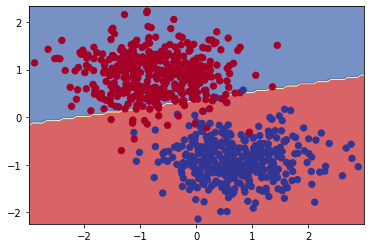

training loss: 1.4082454442977905
validation accuracy: 0.05


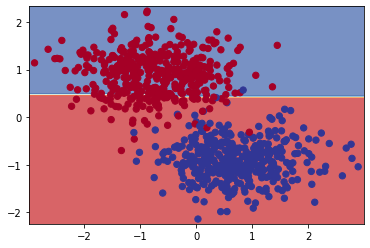

training loss: 1.0780071020126343
validation accuracy: 0.14


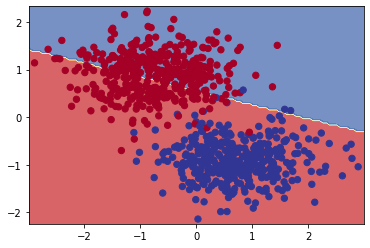

training loss: 0.8399019837379456
validation accuracy: 0.27


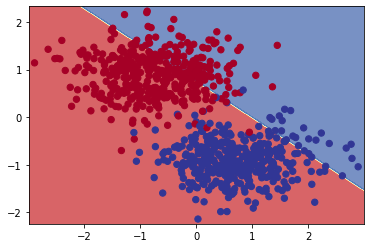

training loss: 0.6738988757133484
validation accuracy: 0.48


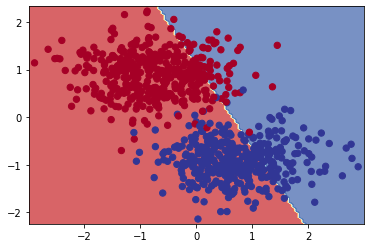

training loss: 0.5580299496650696
validation accuracy: 0.7


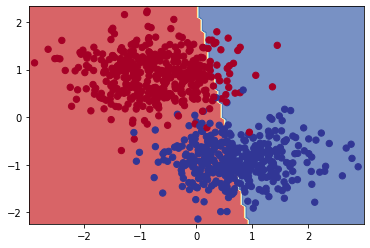

training loss: 0.4753563404083252
validation accuracy: 0.84


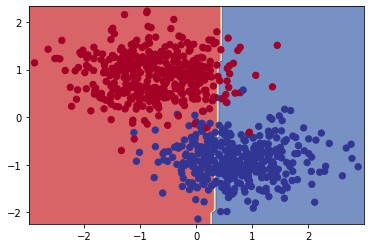

training loss: 0.4145793616771698
validation accuracy: 0.89


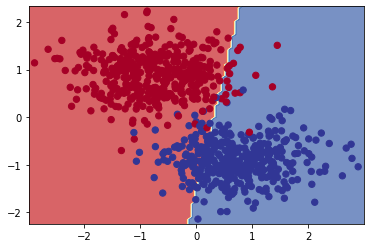

training loss: 0.36851954460144043
validation accuracy: 0.9


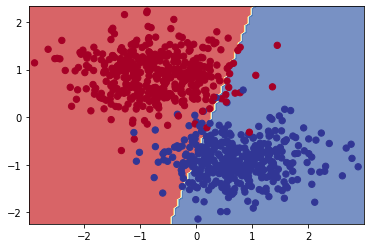

training loss: 0.3326253592967987
validation accuracy: 0.91


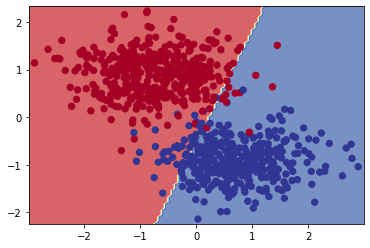

training loss: 0.3039594888687134
validation accuracy: 0.92


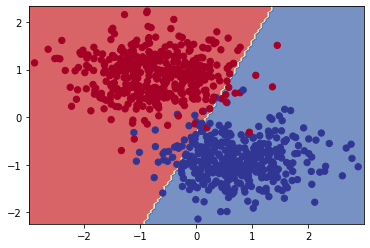

training loss: 0.280577152967453
validation accuracy: 0.95


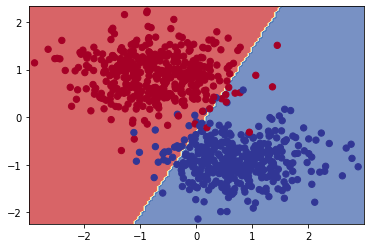

training loss: 0.26115530729293823
validation accuracy: 0.96


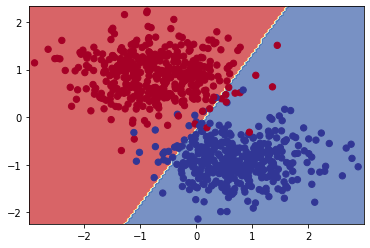

training loss: 0.24476931989192963
validation accuracy: 0.96


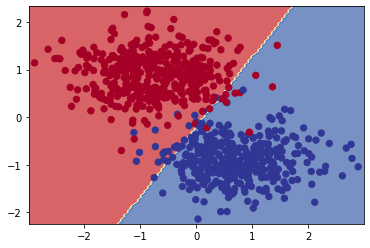

training loss: 0.23075751960277557
validation accuracy: 0.96


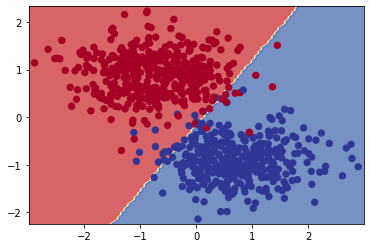

training loss: 0.21863509714603424
validation accuracy: 0.96


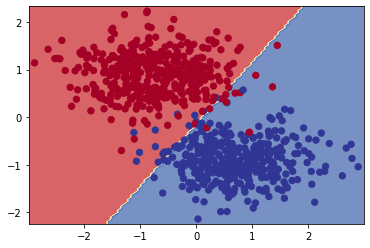

In [27]:
#number of times we iterate trough the train set
num_epochs = 8000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step()
        
    if epoch % 500 == 0:    
      print("training loss: {}".format(loss))    
      model.eval()
      with torch.inference_mode(): 
        predictions_val = torch.squeeze(torch.round(torch.sigmoid(model(X_val)))).detach().numpy()
        print("validation accuracy: {}".format(accuracy_score(y_val,predictions_val)))
      model.train()
      plot_decision_boundary(model, X_train, y_train)
      plt.show()

## Computing predictions and evaluating the model

After fitting the modelparameters (and optimizing the hyperparameters on the validation set) we can compute the prediction accuracy on the test set. 

In [28]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.round(torch.sigmoid(torch.squeeze(predictions_test))).detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions_test)))

test set accuracy: 0.97


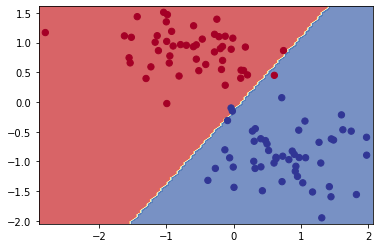

In [29]:
plot_decision_boundary(model, X_test, y_test)


## Saving and loading a model

The recommended way for saving a model for inference (making predictions) is by saving the modelparameter values in `state_dict()`.

We call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`.


In [30]:
model_filename = "model_logistic_regression.pth"
torch.save(obj=model.state_dict(), f=model_filename) 

To load a model, we first load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).


In [31]:
loaded_model = LogisticRegression(input_dim, output_dim)

loaded_model.load_state_dict(torch.load(f=model_filename))

<All keys matched successfully>

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [32]:
loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) 